In [91]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import math

## Data cleaning

The following cells will improve the DF, which presents inconsistency, missing values and outliers, thanks to consideration done during the data understanding phase

In [92]:
# load df
df = pd.read_csv("../dataset/customer_supermarket_understanding.csv", index_col=0, parse_dates=["BasketDate"], decimal=",")
df.Sale = df.Sale.astype(float)

/Users/tommasocolella/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


For every canceled basket ('C'+'BasketID') check if exists at least one counterpart

In [93]:
df_check = df[(df['BasketID'].str.contains('C')) & (df['ProdID'] != 'D')][['CustomerID','Qta','ProdID']]
for index, col in  df_check.iterrows():
    if df[(df['CustomerID'] == col[0]) & (df['Qta'] == -col[1]) & (df['ProdID'] == col[2])].shape[0] == 0: 
        print(True)
        break

True


Remove from the dataset the rows with canceled basket and possible counterpart (if there are more then one counterpart, the first will be deleted)

In [94]:
df_canceled_basket = df[(df['BasketID'].str.contains('C')) & (df['ProdID'] != 'D')]

rows_with_counterparts = []
rows_without_counterparts = []

for index, col in df_canceled_basket.iterrows():
    df_temp = df[(df['CustomerID'] == col['CustomerID']) & (df['Qta'] == -col['Qta']) & (df['ProdID'] == col['ProdID'])]
    
    if df_temp.shape[0] == 0: 
        rows_without_counterparts.append(index)
    else:
        rows_with_counterparts.append(index)
        rows_with_counterparts.append(df_temp.index[0])
    
'''
print("DF len before dropping rows with counterparts: ", len(df))
df_canceled_basket = df.drop(df.index[rows_with_counterparts])
print("DF len after deleting rows with counterparts: ", len(df_canceled_basket))

df_canceled_basket = df_canceled_basket.drop(df_canceled_basket.index[rows_without_counterparts])
print("DF len after deleting rows without counterparts: ", len(df_canceled_basket))
'''

rows_to_be_dropped = rows_with_counterparts + rows_without_counterparts

df_canceled_basket = df.drop(df.index[rows_to_be_dropped])

print("Total number of dropped rows: ", len(df)-len(df_canceled_basket))

Total number of dropped rows:  11775


In [95]:
df = df_canceled_basket

In [96]:
# inconsistency resolution

def inconsistency_resolver(path,col1,col2):
    
    with open(path, 'r') as f:
        inconsistent_list = json.load(f)
        
    df_inconsistent = df[df[col1].isin(inconsistent_list)]

    df_grouped = df_inconsistent.groupby([col1,col2]).size().reset_index()
    
    df_grouped = df_grouped.sort_values(0, ascending=False).drop_duplicates(col1).sort_index()
    
    mydict = pd.Series(df_grouped[col2].values,index=df_grouped[col1]).to_dict()
    
    for k,v in mydict.items():
        
        df.loc[df[col1] == k, col2] = v

inconsistency_resolver("../dataset/inconsistent_CustomerID_CustomerCountry.json","CustomerID","CustomerCountry") 
inconsistency_resolver("../dataset/inconsistent_ProdID_ProdDescr.json","ProdID","ProdDescr") 

In [97]:
''' check if inconsistency has been solved
def inconsistent_set(K,V):
    
    inconsistentset = list()

    for key in df[K].unique().tolist():
        temp_df = df[df[K] == key]
        valueslist = temp_df[V].tolist()
        for value in valueslist:
            if(valueslist[0] != value):
                inconsistentset.append(key)
                break;
    return inconsistentset


# 1
ProdID_ProdDescr_IS = inconsistent_set("ProdID","ProdDescr")
            
print("Number of not consistent ProdDescr:", len(ProdID_ProdDescr_IS))

#3 
CustomerID_CustomerCountry_IS = inconsistent_set("CustomerID","CustomerCountry")
            
print("Number of not consistent CustomerCountry:", len(CustomerID_CustomerCountry_IS))
'''

' check if inconsistency has been solved\ndef inconsistent_set(K,V):\n    \n    inconsistentset = list()\n\n    for key in df[K].unique().tolist():\n        temp_df = df[df[K] == key]\n        valueslist = temp_df[V].tolist()\n        for value in valueslist:\n            if(valueslist[0] != value):\n                inconsistentset.append(key)\n                break;\n    return inconsistentset\n\n\n# 1\nProdID_ProdDescr_IS = inconsistent_set("ProdID","ProdDescr")\n            \nprint("Number of not consistent ProdDescr:", len(ProdID_ProdDescr_IS))\n\n#3 \nCustomerID_CustomerCountry_IS = inconsistent_set("CustomerID","CustomerCountry")\n            \nprint("Number of not consistent CustomerCountry:", len(CustomerID_CustomerCountry_IS))\n'

DF without inconsistency serialization

In [98]:
df.to_csv("../dataset/customer_supermarket_no_inconsistency.csv", sep="\t", decimal=",")

## Indicators

In [99]:
# first of all we deserialize our dataframe
df = pd.read_csv("../dataset/customer_supermarket_no_inconsistency.csv", sep="\t", index_col=0, parse_dates=["BasketDate"], decimal=",")
# second remove outliers from df
df = df[df['Outlier'] == False]
print(df.head())
print(df.info())

  BasketID          BasketDate  ProdID  Qta  Sale  CustomerID CustomerCountry  \
0   536365 2010-01-12 08:26:00   21730    6  4.25       17850  United Kingdom   
1   536365 2010-01-12 08:26:00   22752    2  7.65       17850  United Kingdom   
2   536365 2010-01-12 08:26:00   71053    6  3.39       17850  United Kingdom   
3   536365 2010-01-12 08:26:00  84029E    6  3.39       17850  United Kingdom   
4   536365 2010-01-12 08:26:00  84029G    6  3.39       17850  United Kingdom   

                             ProdDescr  Outlier  
0    GLASS STAR FROSTED T-LIGHT HOLDER    False  
1         SET 7 BABUSHKA NESTING BOXES    False  
2                  WHITE METAL LANTERN    False  
3       RED WOOLLY HOTTIE WHITE HEART.    False  
4  KNITTED UNION FLAG HOT WATER BOTTLE    False  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 384702 entries, 0 to 396362
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----     

# I - indicator
the total number of items purchased by a customer during the period of
observation.

In [100]:
df_i = df.groupby("CustomerID").sum().reset_index()
df_i = df_i[["CustomerID", "Qta"]]
df_i

,CustomerID,Qta
0,12347,2458
1,12348,2341
2,12349,630
3,12350,197
4,12352,470
...,...,...
4309,18280,45
4310,18281,54
4311,18282,103
4312,18283,1357


In [101]:
df_i.sort_values(by='Qta', ascending=False)

,CustomerID,Qta
1680,14646,188034
1869,14911,77451
54,12415,75216
3753,17511,63149
4180,18102,60164
...,...,...
2859,16257,2
2999,16454,2
2993,16446,2
4078,17956,1


# Iu - indicator
the number of distinct items bought by a customer in the period of
observation.

In [102]:
df_iu = df.groupby('CustomerID')['ProdID'].nunique().reset_index()
df_iu

,CustomerID,ProdID
0,12347,103
1,12348,22
2,12349,72
3,12350,17
4,12352,58
...,...,...
4309,18280,10
4310,18281,7
4311,18282,12
4312,18283,263


# Imax - indicator
the maximum number of items purchased by a customer during a
shopping session

In [103]:
df_imax = df.groupby(["CustomerID", "BasketID"]).Qta.sum()
df_imax = df_imax.groupby(level=0).head(1).reset_index()

#df_imax = df_imax.max(level=0)

df_imax

,CustomerID,BasketID,Qta
0,12347,537626,319
1,12348,539318,1254
2,12349,577609,630
3,12350,543037,197
4,12352,544156,98
...,...,...,...
4309,18280,545712,45
4310,18281,556464,54
4311,18282,562525,75
4312,18283,540350,61


# E - indicator
the Shannon entropy on the purchasing behaviour of the customer

In [104]:
# Entropy helper function 
import numpy as np
from scipy.stats import entropy
from math import log, e
import pandas as pd   

""" Usage: pandas_entropy(df['column1']) """

def pandas_entropy(column, base=None):
    vc = pd.Series(column).value_counts(normalize=True, sort=False)
    base = e if base is None else base
    return -(vc * np.log(vc)/np.log(base)).sum()

In [105]:
df_temp = df.groupby(["CustomerID", "BasketID"]).Qta.sum().reset_index()
df_entropy = pd.DataFrame(df.CustomerID.unique(), columns=["CustomerID"])

entropies = []

for customer in df_temp.CustomerID.unique():
    customer_baskets = df_temp[df_temp.CustomerID == customer]
    entropies.append(pandas_entropy(customer_baskets["Qta"]))
    #print(df_temp[df_temp.CustomerID == customer])
    
df_entropy["Entropy"] = entropies

# Additional indicators

### Total Spending
We compute the total amount spent by each customer in the observation period

In [106]:
df_tot = df.groupby(["CustomerID"]).Sale.sum()
df_tot = df_tot.groupby(level=0).head(1).reset_index()

print(df_tot)

      CustomerID     Sale
0          12347   481.21
1          12348   178.71
2          12349   305.10
3          12350    65.30
4          12352   497.12
...          ...      ...
4309       18280    47.65
4310       18281    39.36
4311       18282    62.39
4312       18283  1174.33
4313       18287   104.55

[4314 rows x 2 columns]


### Average spending
We compute the average basket value for each user

In [107]:
df_customer_basket_groupby_sum = df.groupby(["CustomerID",'BasketID'], as_index=False).agg({"Sale":sum})
df_mean = df_customer_basket_groupby_sum.groupby('CustomerID')['Sale'].mean()
df_mean = df_mean.groupby(level=0).head(1).reset_index()

print(df_mean)

      CustomerID        Sale
0          12347   68.744286
1          12348   44.677500
2          12349  305.100000
3          12350   65.300000
4          12352   71.017143
...          ...         ...
4309       18280   47.650000
4310       18281   39.360000
4311       18282   31.195000
4312       18283   73.395625
4313       18287   34.850000

[4314 rows x 2 columns]


### Discounts per user
We count the number of times a customer used a discount

In [126]:
df_discounts = df.where(df.ProdDescr == "Discount").groupby(["CustomerID"]).count()
print(df_discounts)

            BasketID  BasketDate  ProdID  Qta  Sale  CustomerCountry  \
CustomerID                                                             
12830.0            1           1       1    1     1                1   
12901.0            1           1       1    1     1                1   
13137.0            1           1       1    1     1                1   
13316.0            1           1       1    1     1                1   
13408.0            4           4       4    4     4                4   
13694.0            2           2       2    2     2                2   
14031.0            1           1       1    1     1                1   
14527.0           28          28      28   28    28               28   
14646.0            1           1       1    1     1                1   
14912.0            1           1       1    1     1                1   
15299.0            1           1       1    1     1                1   
15498.0            2           2       2    2     2             

### Putting together all indicators

In [136]:
print(df_tot.Sale)

0        481.21
1        178.71
2        305.10
3         65.30
4        497.12
         ...   
4309      47.65
4310      39.36
4311      62.39
4312    1174.33
4313     104.55
Name: Sale, Length: 4314, dtype: float64


In [139]:
df_indicators = pd.DataFrame(df.CustomerID.unique(), columns=["CustomerID"]).sort_values(by=['CustomerID'])
df_indicators["Entropy"] = df_entropy.Entropy.values
df_indicators["i"] = df_i.Qta.values
df_indicators["iu"] = df_iu.ProdID.values
df_indicators["imax"] = df_imax.Qta.values
df_indicators["tot_sales"] = df_tot.Sale.values
df_indicators["mean_sales"] = df_mean.Sale.values

indicators.to_csv("../dataset/indicators.csv")
print(df_indicators)

      CustomerID   Entropy     i   iu  imax  tot_sales  mean_sales
407        12347  1.945910  2458  103   319     481.21   68.744286
805        12348  1.386294  2341   22  1254     178.71   44.677500
4181       12349 -0.000000   630   72   630     305.10  305.100000
1343       12350 -0.000000   197   17   197      65.30   65.300000
1493       12352  1.945910   470   58    98     497.12   71.017143
...          ...       ...   ...  ...   ...        ...         ...
1762       18280 -0.000000    45   10    45      47.65   47.650000
2795       18281 -0.000000    54    7    54      39.36   39.360000
3173       18282  0.693147   103   12    75      62.39   31.195000
913        18283  2.566599  1357  263    61    1174.33   73.395625
2627       18287  1.098612  1586   59   488     104.55   34.850000

[4314 rows x 7 columns]


In [131]:
print(df_indicators.discounts_used.unique())

[nan]


### Customer Spending Profile 
we categorize each customer as either low, medium, or high spending according to their average expense

range(0, 1050, 50)


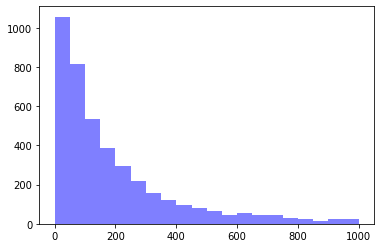

CustomerID
12347      high
12348    medium
12349      high
12350       low
12352      high
          ...  
18280       low
18281       low
18282       low
18283      high
18287    medium
Name: Sale, Length: 4314, dtype: category
Categories (3, object): [low < medium < high]

In [110]:
df_profile = df.groupby(["CustomerID"]).agg({"Sale":sum, "Qta":sum})

binwidth = 50
bins=range(0, 1000 + binwidth, binwidth)
print(bins)
n, bins, patches = plt.hist(df_profile.Sale, bins=bins, facecolor='blue', alpha=0.5)
plt.show()

spending_profile = pd.cut(df_profile['Sale'], bins=[0, 100, 300, df_profile.Sale.max()], include_lowest=True, labels=["low", "medium", "high"])
spending_profile

### The average cost of a basket

In [111]:
df_customer_basket_groupby_sum = df.groupby(["CustomerID",'BasketID'], as_index=False).agg({"Sale":sum})

series_customer_basket_groupby_mean = df_customer_basket_groupby_sum.groupby('CustomerID')['Sale'].mean()
df_customer_basket_groupby_mean = pd.DataFrame(df_customer_basket_groupby_mean)

binwidth = 50
bins=range(0, 400 + binwidth, binwidth)
print(bins)
n, bins, patches = plt.hist(df_customer_basket_groupby_mean.Sale, bins=bins, facecolor='blue', alpha=0.5)
plt.savefig('../output/total_receipt_price_distribution.png')
plt.show()

basket_cost_profile = pd.cut(df_customer_basket_groupby_mean['Sale'], bins=[0, 50, 200, df_customer_basket_groupby_mean.Sale.max()], include_lowest=True, labels=["low", "medium", "high"])
basket_cost_profile

NameError: name 'df_customer_basket_groupby_mean' is not defined

### Sales per country

In [ ]:
df_sales_per_country = df.groupby(["CustomerCountry"])["Sale"].sum().reset_index()
print(df_sales_per_country)

In [ ]:
# the pie plot is horrible because of england, that probably has some outliers
#explode=np.zeros(len(df_sales_per_country.CustomerCountry))

plt.pie(df_sales_per_country.Sale, labels=df_sales_per_country.CustomerCountry, autopct='%1.1f%%')
plt.show()

### Most bought items

In [ ]:
cols_dropped = [2, 3, 6]
df_most_bought = df.groupby(["ProdID", "ProdDescr"]).sum().reset_index()
#df_most_bought = df_most_bought.drop(df_most_bought.columns[cols_dropped], axis=1)
df_most_bought = df_most_bought.sort_values(by="Qta", ascending=False)
#df_most_bought = df_most_bought.groupby(level=0).head(1).reset_index()
df_most_bought 

#print(df[df.ProdDescr == "Discount"])

In [ ]:
plt.pie(df_most_bought[:10].Qta, labels=df_most_bought[:10].ProdDescr, autopct='%1.1f%%')
plt.savefig("../output/most_bought_item_piechart.png")
plt.show()

### Most bought item per country


In [ ]:
#cols_dropped = [3, 4, 7]
df_mb_country = df.groupby(["ProdID", "ProdDescr", "CustomerCountry"]).sum().reset_index()
df_mb_country = df_mb_country.drop(["Sale"], axis = 1)

df_mb_country = df_mb_country[df_mb_country.groupby(["CustomerCountry"])["Qta"].transform("max") == df_mb_country["Qta"]].reset_index()

#df_mb_country = df_mb_country.groupby(["CustomerCountry"]).agg({"Qta" : "max"}).reset_index()
#print(df_mb_country.CustomerCountry.unique())


print(df_mb_country)


### Linear Graphs

In [ ]:
# start and end datetimes
print(df.BasketDate.min(), df.BasketDate.max())

In [ ]:
weekly = df.set_index("BasketDate").copy()
weekly = weekly.groupby(pd.Grouper(freq='M'))["Qta"].sum()

#print(weekly)

plt.figure(figsize=(16,5))
plt.plot(weekly.index, weekly, color='tab:blue', marker="o")